In [1]:
import torch
from torch import nn
from einops import rearrange

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler,autocast
import torch.optim as optim
#import torch.nn.functional as F

import sys
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split

/tmp/ipykernel_49936/2513862769.py:15: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
root_path = r"/home/srikanth/Dataset/Hit-GPRec-merged"
dataset_path = os.listdir(root_path)

DATASET AND DATALOADER

In [4]:
class_labels = []
for item in dataset_path:
    #print(item)
    all_classes = os.listdir(root_path + '/' +item)
    for top_object in all_classes:
        sub_objects = os.listdir(root_path  + '/' +item + '/' +top_object)
        for sub_object in sub_objects:
            class_labels.append((item,str(root_path + '/' +item + '/' +top_object + '/' +sub_object)))
            
df = pd.DataFrame(data=class_labels, columns=['labels', 'image'])
y=list(df['labels'].values)
image=df['image']

In [5]:
images, y= shuffle(image,y, random_state=1)
train_x, test_x, train_y, test_y = train_test_split(images, y, test_size=0.2, random_state=415)
test_x = test_x.reset_index(drop=True)
train_x = train_x.reset_index(drop=True)
test_x, val_x, test_y, val_y = train_test_split(test_x,test_y, test_size=0.5, random_state=415)
test_x = test_x.reset_index(drop=True)
#train_y=list(train_y)
train_df=pd.DataFrame({'filepaths':train_x,'labels':train_y})
valid_df=pd.DataFrame({'filepaths':val_x,'labels':val_y})
test_df=pd.DataFrame({'filepaths':test_x,'labels':test_y})

In [6]:
classes=list(train_df['labels'].unique())
class_count=len(classes)

In [7]:
labels = df['labels'].unique()
num_labels = len(labels)
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'Palmar wrist pronated': 0, 'Pinch': 1, 'Tripod': 2, 'Palmar wrist neutral': 3}
{0: 'Palmar wrist pronated', 1: 'Pinch', 2: 'Tripod', 3: 'Palmar wrist neutral'}


In [8]:
class ImageDataset():
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224, 224), antialias=True),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
        ])
        self.label_mapping = label2id

    def __len__(self):
        return len(self.df)

    def get_images(self, idx):
        return self.transform(Image.open(self.df.iloc[idx]['filepaths']))

    def get_labels(self, idx):
        label = self.df.iloc[idx]['labels']
        return torch.tensor(self.label_mapping[label], dtype=torch.long)

    def __getitem__(self, idx):
        train_images = self.get_images(idx)
        train_labels = self.get_labels(idx)

        return train_images, train_labels

In [9]:
# Create dataset objects
train_dataset = ImageDataset(train_df, transform=transforms)
val_dataset = ImageDataset(valid_df, transform=transforms)
test_dataset = ImageDataset(test_df, transform=transforms)

In [10]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

MODEL

In [11]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

In [12]:
class CViT(nn.Module): 
    def __init__(self, image_size=224, patch_size=7, num_classes=4, channels=3, 
                 dim=1024, depth=6, heads=8, mlp_dim=2048):
        super().__init__() 
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'

        self.features = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),      
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),      
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),      
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),      
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),      
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),      
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        num_patches = (7 // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(32, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = self.features(img)
        y = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        y = self.patch_to_embedding(y)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, y), 1)
        shape=x.shape[0]
        x += self.pos_embedding[0:shape]
        x = self.transformer(x, mask)
        x = self.to_cls_token(x[:, 0])
        
        return self.mlp_head(x)

In [13]:
# Initialize your model, optimizer, and loss function
model = CViT(image_size=224, patch_size=7, num_classes=4, channels=512,
            dim=1024, depth=6, heads=8, mlp_dim=2048)
model.to(device)
#beta1 = 0.9
#beta2 = 0.999
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01) 
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
num_epochs = 40

In [14]:
module_path = '/home/srikanth/Downloads/going_modular'
sys.path.append(os.path.dirname(module_path))
from going_modular import engine


model_results = engine.train(model=model,
                           train_dataloader=train_loader,
                           valid_dataloader = val_loader,
                           optimizer=optimizer,
                           loss_fn=criterion,
                           epochs=num_epochs,
                           device=device)

  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1936 | train_acc: 0.4952 | val_loss: 1.2430 | val_acc: 0.4910


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 1.0293 | train_acc: 0.5543 | val_loss: 0.8290 | val_acc: 0.6477


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.7673 | train_acc: 0.6828 | val_loss: 0.7907 | val_acc: 0.6772


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.6766 | train_acc: 0.7335 | val_loss: 0.8599 | val_acc: 0.6554


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.6358 | train_acc: 0.7533 | val_loss: 0.7364 | val_acc: 0.6974


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.6179 | train_acc: 0.7629 | val_loss: 0.6641 | val_acc: 0.7492


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.5851 | train_acc: 0.7770 | val_loss: 0.5480 | val_acc: 0.7987


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.5493 | train_acc: 0.7957 | val_loss: 0.6157 | val_acc: 0.7609


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.5348 | train_acc: 0.8007 | val_loss: 0.6336 | val_acc: 0.7420


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.5271 | train_acc: 0.8031 | val_loss: 0.6158 | val_acc: 0.7523


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.4976 | train_acc: 0.8154 | val_loss: 0.5089 | val_acc: 0.8087


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.4739 | train_acc: 0.8272 | val_loss: 0.6150 | val_acc: 0.7850


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.4701 | train_acc: 0.8297 | val_loss: 0.5218 | val_acc: 0.8018


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.4534 | train_acc: 0.8368 | val_loss: 0.6392 | val_acc: 0.7548


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.4492 | train_acc: 0.8379 | val_loss: 0.4891 | val_acc: 0.8177


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.4346 | train_acc: 0.8423 | val_loss: 0.4630 | val_acc: 0.8366


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.4316 | train_acc: 0.8457 | val_loss: 0.7058 | val_acc: 0.7494


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.4278 | train_acc: 0.8484 | val_loss: 0.6705 | val_acc: 0.7607


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.4220 | train_acc: 0.8493 | val_loss: 0.4456 | val_acc: 0.8400


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.4118 | train_acc: 0.8538 | val_loss: 0.4017 | val_acc: 0.8576


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 0.4077 | train_acc: 0.8568 | val_loss: 0.3631 | val_acc: 0.8742


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 0.3974 | train_acc: 0.8596 | val_loss: 0.3911 | val_acc: 0.8618


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.3934 | train_acc: 0.8608 | val_loss: 0.8759 | val_acc: 0.6795


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.3938 | train_acc: 0.8601 | val_loss: 0.4535 | val_acc: 0.8398


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.3800 | train_acc: 0.8697 | val_loss: 0.5062 | val_acc: 0.8228


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 26 | train_loss: 0.3745 | train_acc: 0.8701 | val_loss: 0.4882 | val_acc: 0.8274


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 27 | train_loss: 0.3718 | train_acc: 0.8720 | val_loss: 0.3028 | val_acc: 0.9031


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 28 | train_loss: 0.3697 | train_acc: 0.8712 | val_loss: 0.3494 | val_acc: 0.8857


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 29 | train_loss: 0.3601 | train_acc: 0.8777 | val_loss: 0.3970 | val_acc: 0.8624


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 30 | train_loss: 0.3593 | train_acc: 0.8797 | val_loss: 0.4232 | val_acc: 0.8687


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 31 | train_loss: 0.3483 | train_acc: 0.8810 | val_loss: 0.4832 | val_acc: 0.8278


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 32 | train_loss: 0.3530 | train_acc: 0.8816 | val_loss: 0.3575 | val_acc: 0.8708


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 33 | train_loss: 0.3483 | train_acc: 0.8841 | val_loss: 0.4628 | val_acc: 0.8370


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 34 | train_loss: 0.3446 | train_acc: 0.8849 | val_loss: 0.5564 | val_acc: 0.7938


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 35 | train_loss: 0.3406 | train_acc: 0.8850 | val_loss: 0.3370 | val_acc: 0.8941


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 36 | train_loss: 0.3438 | train_acc: 0.8843 | val_loss: 0.3346 | val_acc: 0.8855


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 37 | train_loss: 0.3346 | train_acc: 0.8900 | val_loss: 0.4454 | val_acc: 0.8547


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 38 | train_loss: 0.3322 | train_acc: 0.8888 | val_loss: 0.3409 | val_acc: 0.8865


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 39 | train_loss: 0.3247 | train_acc: 0.8920 | val_loss: 0.3742 | val_acc: 0.8760


  0%|          | 0/2377 [00:00<?, ?it/s]

  0%|          | 0/298 [00:00<?, ?it/s]

Epoch: 40 | train_loss: 0.3228 | train_acc: 0.8914 | val_loss: 0.3042 | val_acc: 0.8951


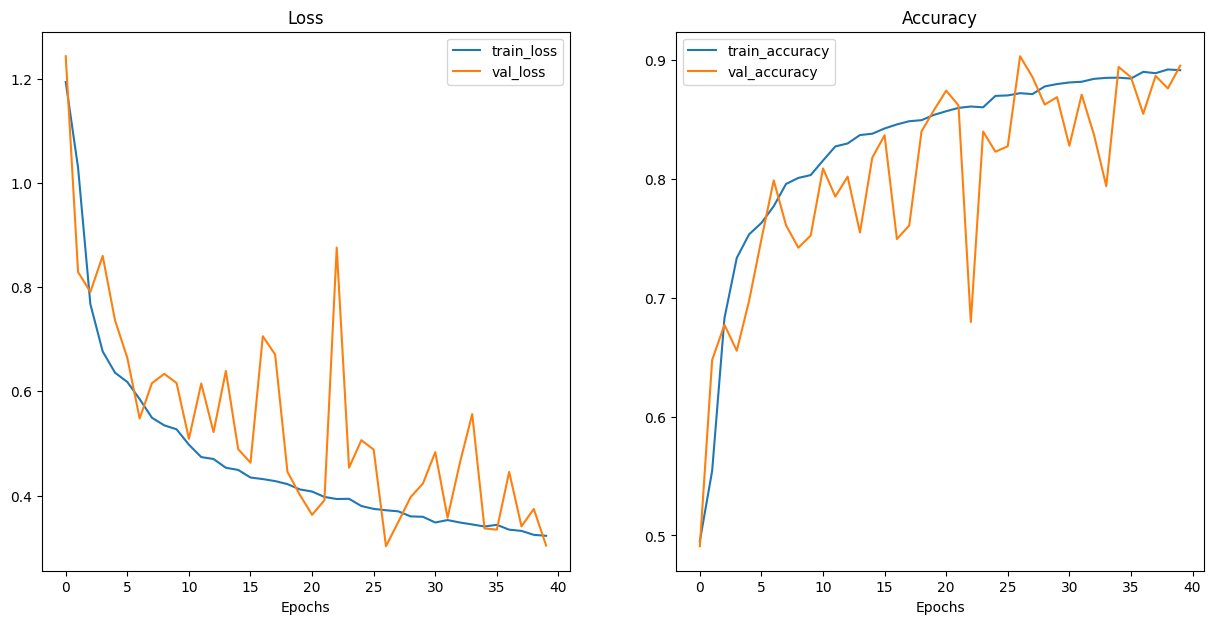

In [15]:
from going_modular.helper_functions import plot_loss_curves
plot_loss_curves(model_results)

In [16]:
# TESTING
test_losses = []
test_accuracies = []

all_preds = []
all_labels = []
model.eval()
total_test_loss = 0.0
correct_test = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item() * images.size(0)
        pred = outputs.argmax(dim=1, keepdim=True)
        correct_test += pred.eq(labels.view_as(pred)).sum().item()
        # Gather predictions and true labels for confusion matrix
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

average_test_loss = total_test_loss / len(test_loader.dataset)
test_losses.append(average_test_loss)
test_accuracies.append(100. * correct_test / len(test_loader.dataset))
print("Test Accuracy: {:.2f}%".format(test_accuracies[-1]))

Test Accuracy: 89.54%


In [17]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
# Classification Report
class_report = classification_report(all_labels, all_preds)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[ 393   14   15    0]
 [  29  778  188    0]
 [   5   78 2167   95]
 [   0    1   72  917]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       422
           1       0.89      0.78      0.83       995
           2       0.89      0.92      0.91      2345
           3       0.91      0.93      0.92       990

    accuracy                           0.90      4752
   macro avg       0.90      0.89      0.90      4752
weighted avg       0.90      0.90      0.89      4752



In [18]:
from tqdm.auto import tqdm

test_losse = []
test_accuracie = []
model.eval() 

# Setup val loss and val accuracy values
test_loss, test_acc = 0, 0
# Turn on inference context manager
with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (images, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
        # Send data to target device
        images, labels = images.to(device), labels.to(device)
        # 1. Forward pass
        test_pred_logits = model(images)
        # 2. Calculate and accumulate loss
        loss = criterion(test_pred_logits, labels)
        test_loss += loss.item()
        # Calculate and accumulate accuracy
        test_pred_labels = test_pred_logits.argmax(dim=1)
        test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)
    return test_loss, test_acc

test_losse.append(test_loss)
test_accuracie.append(100. * tes_acc)
print("Test Accuracy: {:.2f}%".format(test_accuracie[-1]))

SyntaxError: 'return' outside function (808137006.py, line 27)

In [ ]:
def test(model):
    model.eval()

    Sum = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        #output = model(inputs).to(device).float()
        output = model(images)

        _,prediction = torch.max(output,1)

        pred_label = labels[prediction]
        pred_label = pred_label.detach().cpu().numpy()
        main_label = labels.detach().cpu().numpy()
        bool_list  = list(map(lambda x, y: x == y, pred_label, main_label))
        Sum += sum(np.array(bool_list)*1)

    #print('Prediction: ', (Sum/len(test_loader.dataset)*100,'%'))
    print('Prediction: {:.2f}%'.format(Sum / len(test_loader.dataset) * 100))

In [ ]:
test(model)

In [ ]:
from torchsummary import summary
# Print the summary of the model
summary(model, (3, 224, 224)) 

----------------------DONE-------------------------